In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as sk
import numpy as np
import datetime
import psycopg2
import wordcloud

# EDA (Exploratory Data Analysis)

In [316]:
# Initilize the database connector
connector = psycopg2.connect(user = 'platzi',
                            password = 'platzi123',
                            host = 'localhost',
                            port = '5432',
                            database = 'platzi')

### Daily test

In the daily test maked to the population, I group the date by departament and date, that for have information abput the evolution of the politics and health agencies in test apply to the population, and how the actions taken by different politicians affect the curve behavior in their territories. 

In [317]:
query_tests = '''
    SELECT
        Pivot.cantidad AS Cumulative,
        Pivot.origin,
        Pivot.cal_date AS Date,
        CASE WHEN Pivot.Previous = 0 OR Pivot.Previous IS NULL THEN 
            0.0
        ELSE
            ((Pivot.cantidad - Pivot.Previous) / Pivot.Previous) * 100
        END AS Daily_Change_Percent
    FROM (
        SELECT
        T.cantidad,
        D.cal_date,
        O.origin,
        (LAG(T.cantidad) OVER (PARTITION BY O.origin ORDER BY D.cal_date)) AS Previous
        FROM tests T 
            INNER JOIN origins O ON O.origin_id = T.origin_id 
            INNER JOIN dates D ON D.date_id = T.date_id 
        ORDER BY D.cal_date
    ) AS Pivot WHERE Pivot.cal_date >= '2020-05-07' ORDER BY Pivot.cal_date;
'''

df_test = pd.read_sql(query_tests, connector)
df_test.replace({'origin': {'PROCEDENCIA_DESCONOCIDA': float('NaN')}}, inplace = True)
df_test.dropna(subset = ['origin'], inplace = True)
df_test.reset_index(inplace = True)
df_test.drop('index', inplace = True, axis = 1)
df_test

cumulative      origin        date  daily_change_percent
0            0.0    GUAVIARE  2020-05-07              0.000000
1            0.0  SAN ANDRES  2020-05-07              0.000000
2            0.0        META  2020-05-07              0.000000
3            0.0       HUILA  2020-05-07              0.000000
4            0.0       CAUCA  2020-05-07              0.000000
...          ...         ...         ...                   ...
6747    676514.0   ANTIOQUIA  2020-12-03              0.604956
6748     98597.0      TOLIMA  2020-12-03              1.168709
6749    105626.0       CESAR  2020-12-03              0.297209
6750     45015.0       CAUCA  2020-12-03              0.334336
6751     74714.0      NARIÑO  2020-12-03              0.292633

[6752 rows x 4 columns]

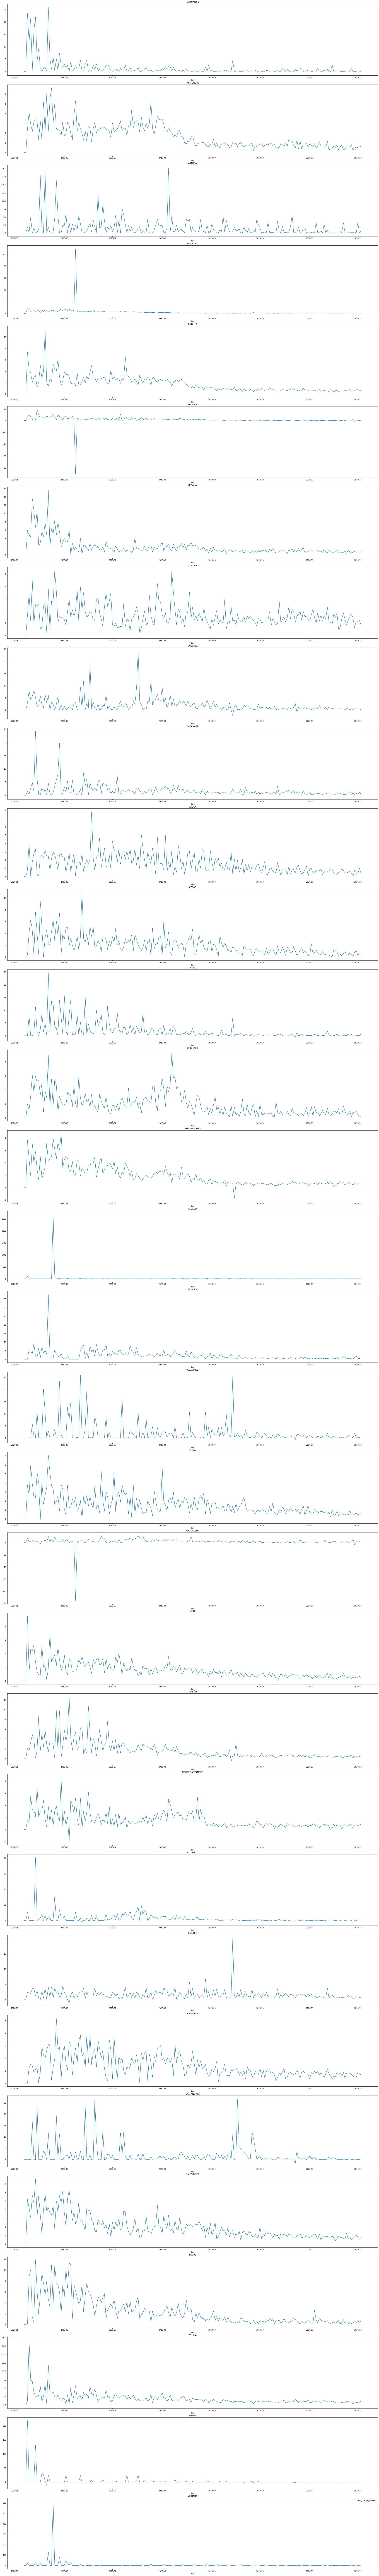

In [318]:
graph_df = df_test.copy()

graph_df.set_index('date', inplace = True)

grouped = graph_df.groupby('origin')['daily_change_percent']

ncols = 1
nrows = int(np.ceil(grouped.ngroups / ncols))


fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30, 200))

fig.tight_layout(pad = 3.0)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax, title = key) 

ax.legend()
plt.show()

In [319]:
stats = grouped.describe()[['mean', 'min', 'max']]

print(stats.sort_values(by = ['mean'], ascending = False)[:3])

              mean        min          max
origin                                    
GUAINIA  14.649673  -2.430872  2700.000000
VICHADA   5.705561  -4.464286   617.391304
VAUPES    2.915945 -11.795775   218.181818


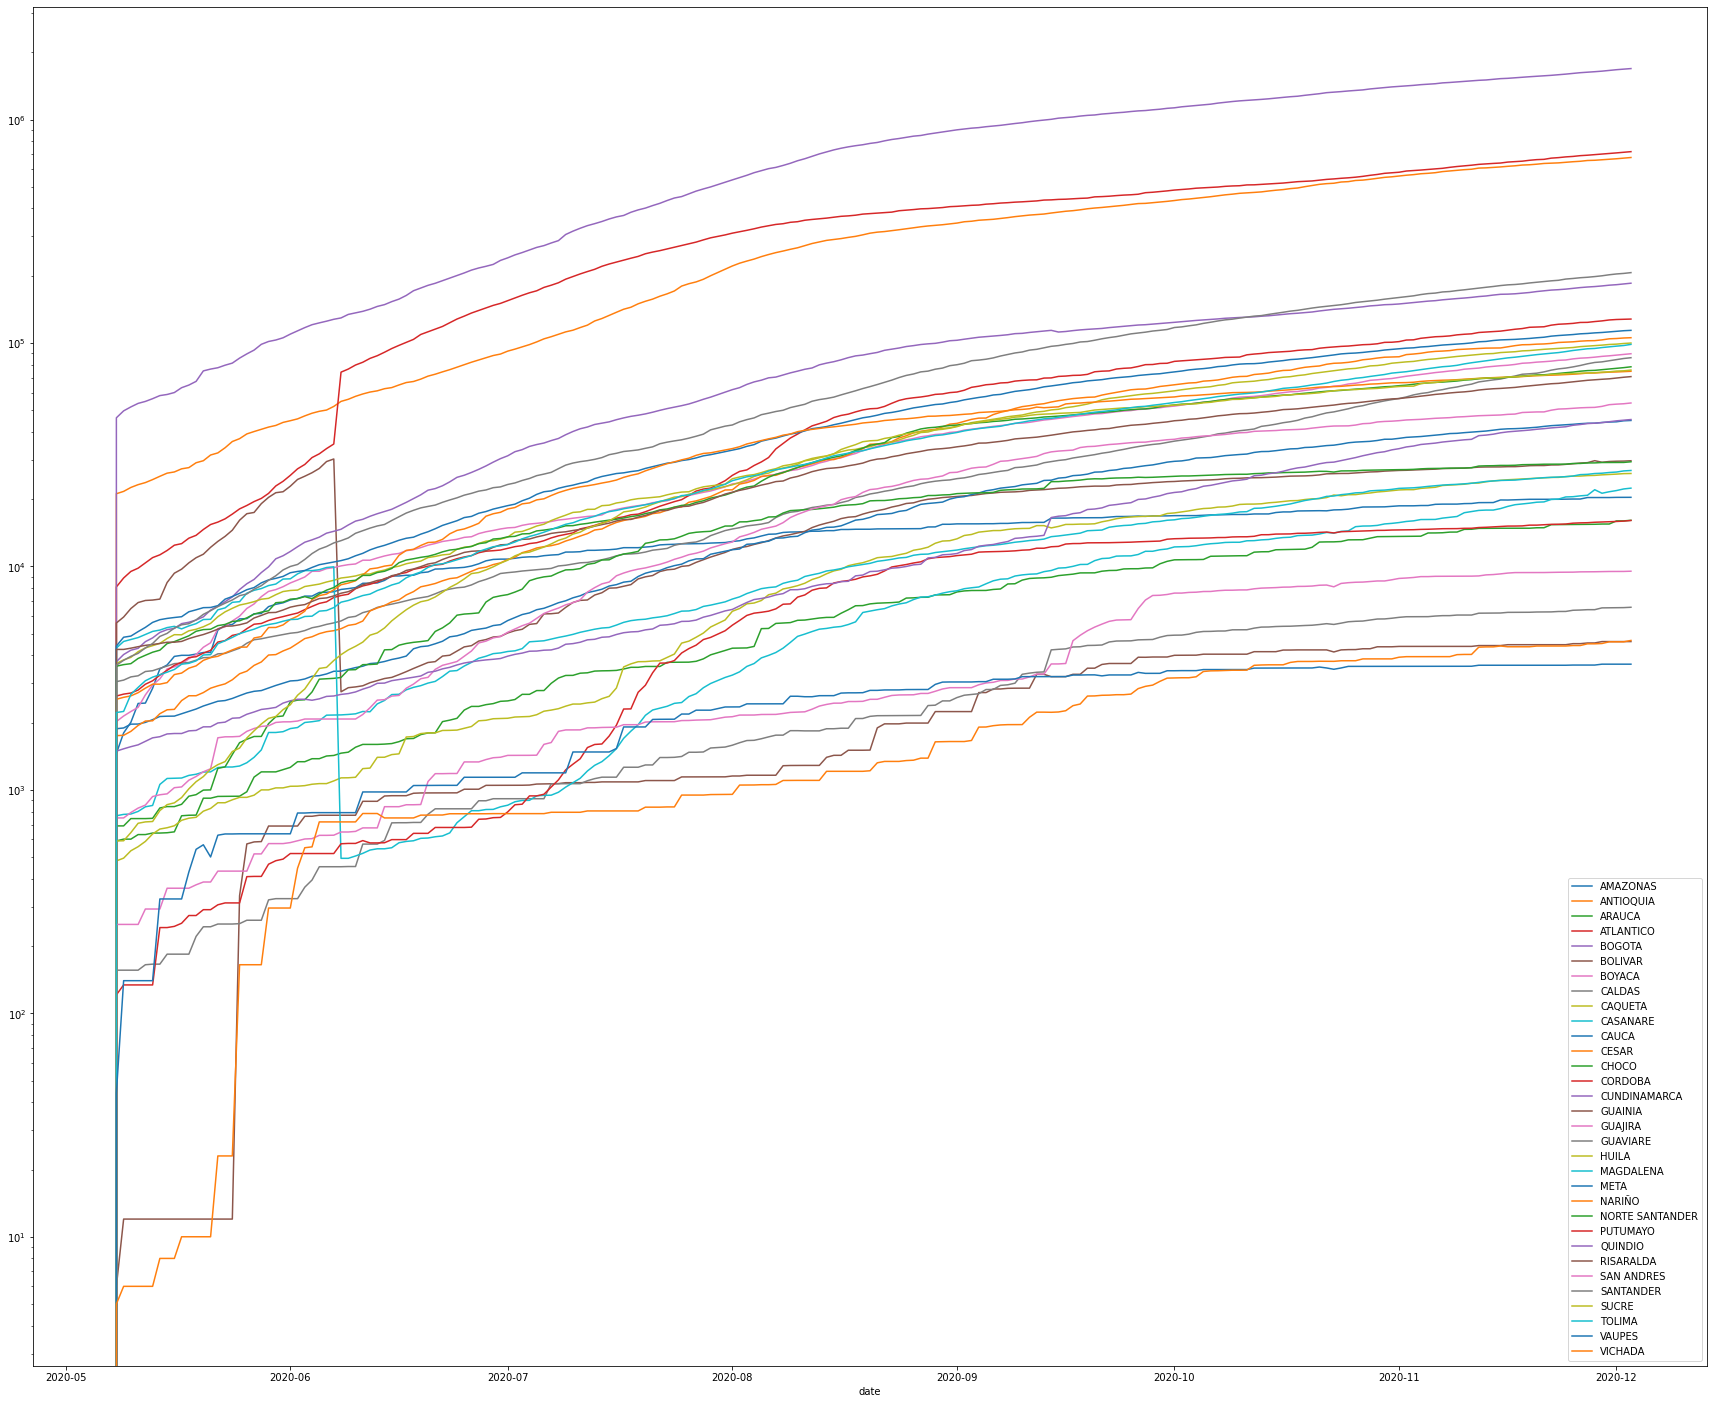

In [320]:
graph_df = df_test.copy()

graph_df.set_index('date', inplace = True)
grouped = graph_df.groupby('origin')['cumulative']

fig = plt.figure()
grouped.plot(logy = True, legend=True, figsize = (30, 25))
fig.savefig('./graphs/log_cases.svg')

In [321]:
stats = grouped.describe()['max']
stats = stats.sort_values(ascending = False).copy()
print('Last 5 departaments by test done')
print(stats[-5:])
print('Fist 5 departaments by test done')
print(stats[:5])

Last 5 departaments by test done
origin
SAN ANDRES    9522.0
GUAVIARE      6567.0
VICHADA       4665.0
GUAINIA       4611.0
VAUPES        3653.0
Name: max, dtype: float64
Fist 5 departaments by test done
origin
BOGOTA          1691600.0
ATLANTICO        718577.0
ANTIOQUIA        676514.0
SANTANDER        206575.0
CUNDINAMARCA     185223.0
Name: max, dtype: float64


### Daily cases

In daily cases analysis by departament and general for all the country I try to understand the behavior of the curve, querying date, origin, cases count, running total of cases in the specified departament and the daily change by departament. I make the same query but with one difference and is that I want to now the percent of the total affected population how many still infected and the percent of total that still in COVID19 issue.

#### Evolution by departament

In [322]:
query_cases_evolution_by_dept = '''
    SELECT 
        Pivot.cal_date AS Date,
        Pivot.origin AS Origin,
        Pivot.count AS Count,
        Pivot.Previous_Cases,
        SUM(Pivot.count) OVER (PARTITION BY Pivot.Origin ORDER BY Pivot.cal_date) AS Cumulative,
        CASE WHEN Pivot.Previous_Cases = 0 OR Pivot.Previous_Cases IS NULL THEN 
            0
        ELSE
            ((Pivot.count - Pivot.Previous_Cases) / Pivot.Previous_Cases) * 100
        END AS Daily_Change_Percent
    FROM (
        SELECT
            D.cal_date,
            O.origin,
            COUNT(C.case_id),
            ROUND(LAG(COUNT(C.case_id)) OVER(PARTITION BY O.origin ORDER BY D.cal_date)) AS Previous_Cases
        FROM cases C 
        INNER JOIN origins O ON O.origin_id = C.origin_id
        INNER JOIN dates D ON D.date_id = C.date_diagnosis_id
        GROUP BY D.cal_date, O.origin
    ) AS Pivot
    ORDER BY Pivot.cal_date
'''

df_cases_evolution_by_dept = pd.read_sql(query_cases_evolution_by_dept, connector)
df_cases_evolution_by_dept.set_index('date', inplace = True) 

query_cases_evolution_general = '''
    SELECT 
        *,
        ( Pivot.Cases / Pivot.Cumulative ) * 100 AS Cumulative_Percent,
        CASE WHEN Pivot.Previous_Cases = 0 OR Pivot.Previous_Cases IS NULL THEN 
            0
        ELSE
            ((Pivot.Cases - Pivot.Previous_Cases) / Pivot.Previous_Cases) * 100
        END AS Daily_Cases_Percent,
        (Pivot.Cumulative - Pivot.Recovered) AS Actives,
        (((Pivot.Cumulative - Pivot.Recovered) / Pivot.Recovered) * 100) AS Cumulative_Recovered_Difference 
    FROM (
        SELECT
            D.cal_date AS Date,
            COUNT(C.case_id) AS Cases,
            ROUND(LAG(COUNT(C.case_id)) OVER(ORDER BY D.cal_date)) AS Previous_Cases,
            SUM(COUNT(C.case_id)) OVER (ORDER BY D.cal_date) AS Cumulative,
            SUM(COUNT(CASE WHEN C.date_recovered_id != -1 THEN 1 END)) OVER (ORDER BY D.cal_date) AS Recovered
        FROM cases C
            INNER JOIN dates D ON D.date_id = C.date_diagnosis_id 
        GROUP BY D.cal_date
    ) AS Pivot
'''

df_cases_evolution_general = pd.read_sql(query_cases_evolution_general, connector)
df_cases_evolution_general.set_index('date', inplace = True)

origin
AMAZONAS           AxesSubplot(0.125,0.125;0.775x0.755)
ANTIOQUIA          AxesSubplot(0.125,0.125;0.775x0.755)
ARAUCA             AxesSubplot(0.125,0.125;0.775x0.755)
ATLANTICO          AxesSubplot(0.125,0.125;0.775x0.755)
BOGOTA             AxesSubplot(0.125,0.125;0.775x0.755)
BOLIVAR            AxesSubplot(0.125,0.125;0.775x0.755)
BOYACA             AxesSubplot(0.125,0.125;0.775x0.755)
CALDAS             AxesSubplot(0.125,0.125;0.775x0.755)
CAQUETA            AxesSubplot(0.125,0.125;0.775x0.755)
CASANARE           AxesSubplot(0.125,0.125;0.775x0.755)
CAUCA              AxesSubplot(0.125,0.125;0.775x0.755)
CESAR              AxesSubplot(0.125,0.125;0.775x0.755)
CHOCO              AxesSubplot(0.125,0.125;0.775x0.755)
CORDOBA            AxesSubplot(0.125,0.125;0.775x0.755)
CUNDINAMARCA       AxesSubplot(0.125,0.125;0.775x0.755)
GUAINIA            AxesSubplot(0.125,0.125;0.775x0.755)
GUAJIRA            AxesSubplot(0.125,0.125;0.775x0.755)
GUAVIARE           AxesSubplot(0.125,0.12

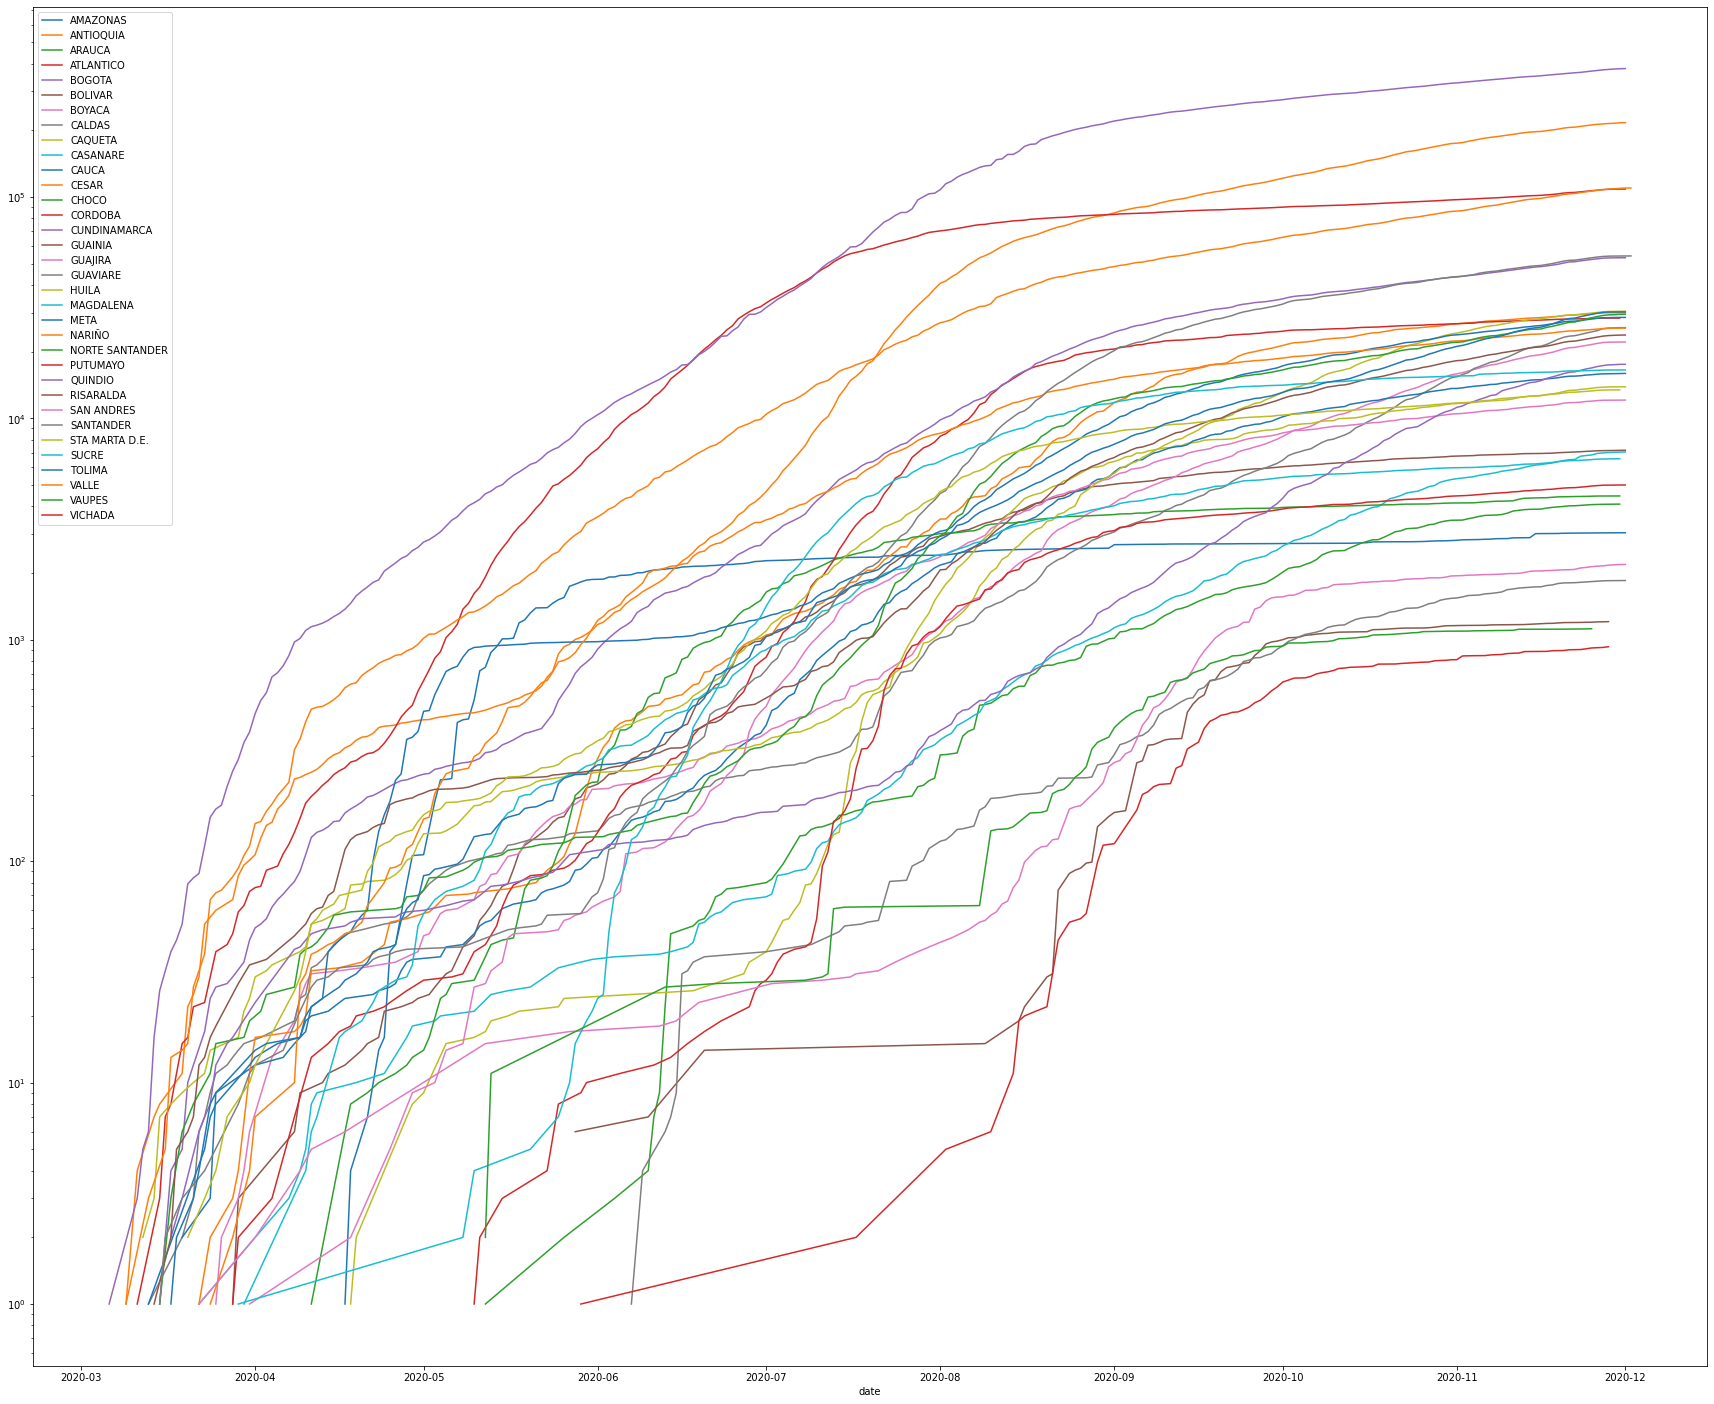

In [323]:
graph_df_evolution_cases_by_dept = df_cases_evolution_by_dept.copy()

grouped = graph_df_evolution_cases_by_dept.groupby('origin')['cumulative']
grouped.plot(logy = True, legend=True, figsize = (30, 25))

In [324]:
stats = df_cases_evolution_by_dept.groupby('origin')[['cumulative', 'daily_change_percent']].describe()
print(stats['cumulative'][['max']].sort_values(by = 'max'))
print(stats['daily_change_percent'][['max', 'mean']].sort_values(by = 'mean', ascending = False))

                      max
origin                   
VICHADA             930.0
VAUPES             1121.0
GUAINIA            1207.0
GUAVIARE           1851.0
SAN ANDRES         2187.0
AMAZONAS           3042.0
ARAUCA             4097.0
CHOCO              4460.0
PUTUMAYO           5000.0
MAGDALENA          6567.0
CASANARE           7045.0
BOLIVAR            7172.0
GUAJIRA           12086.0
CAQUETA           13445.0
STA MARTA D.E.    13876.0
CAUCA             15948.0
SUCRE             16534.0
QUINDIO           17528.0
BOYACA            22116.0
RISARALDA         23772.0
NARIÑO            25553.0
CALDAS            25675.0
CORDOBA           28349.0
META              28554.0
NORTE SANTANDER   29505.0
CESAR             29980.0
TOLIMA            30232.0
HUILA             30448.0
CUNDINAMARCA      53122.0
SANTANDER         54113.0
ATLANTICO        108458.0
VALLE            109685.0
ANTIOQUIA        216380.0
BOGOTA           379675.0
                          max        mean
origin                

<AxesSubplot:xlabel='date'>

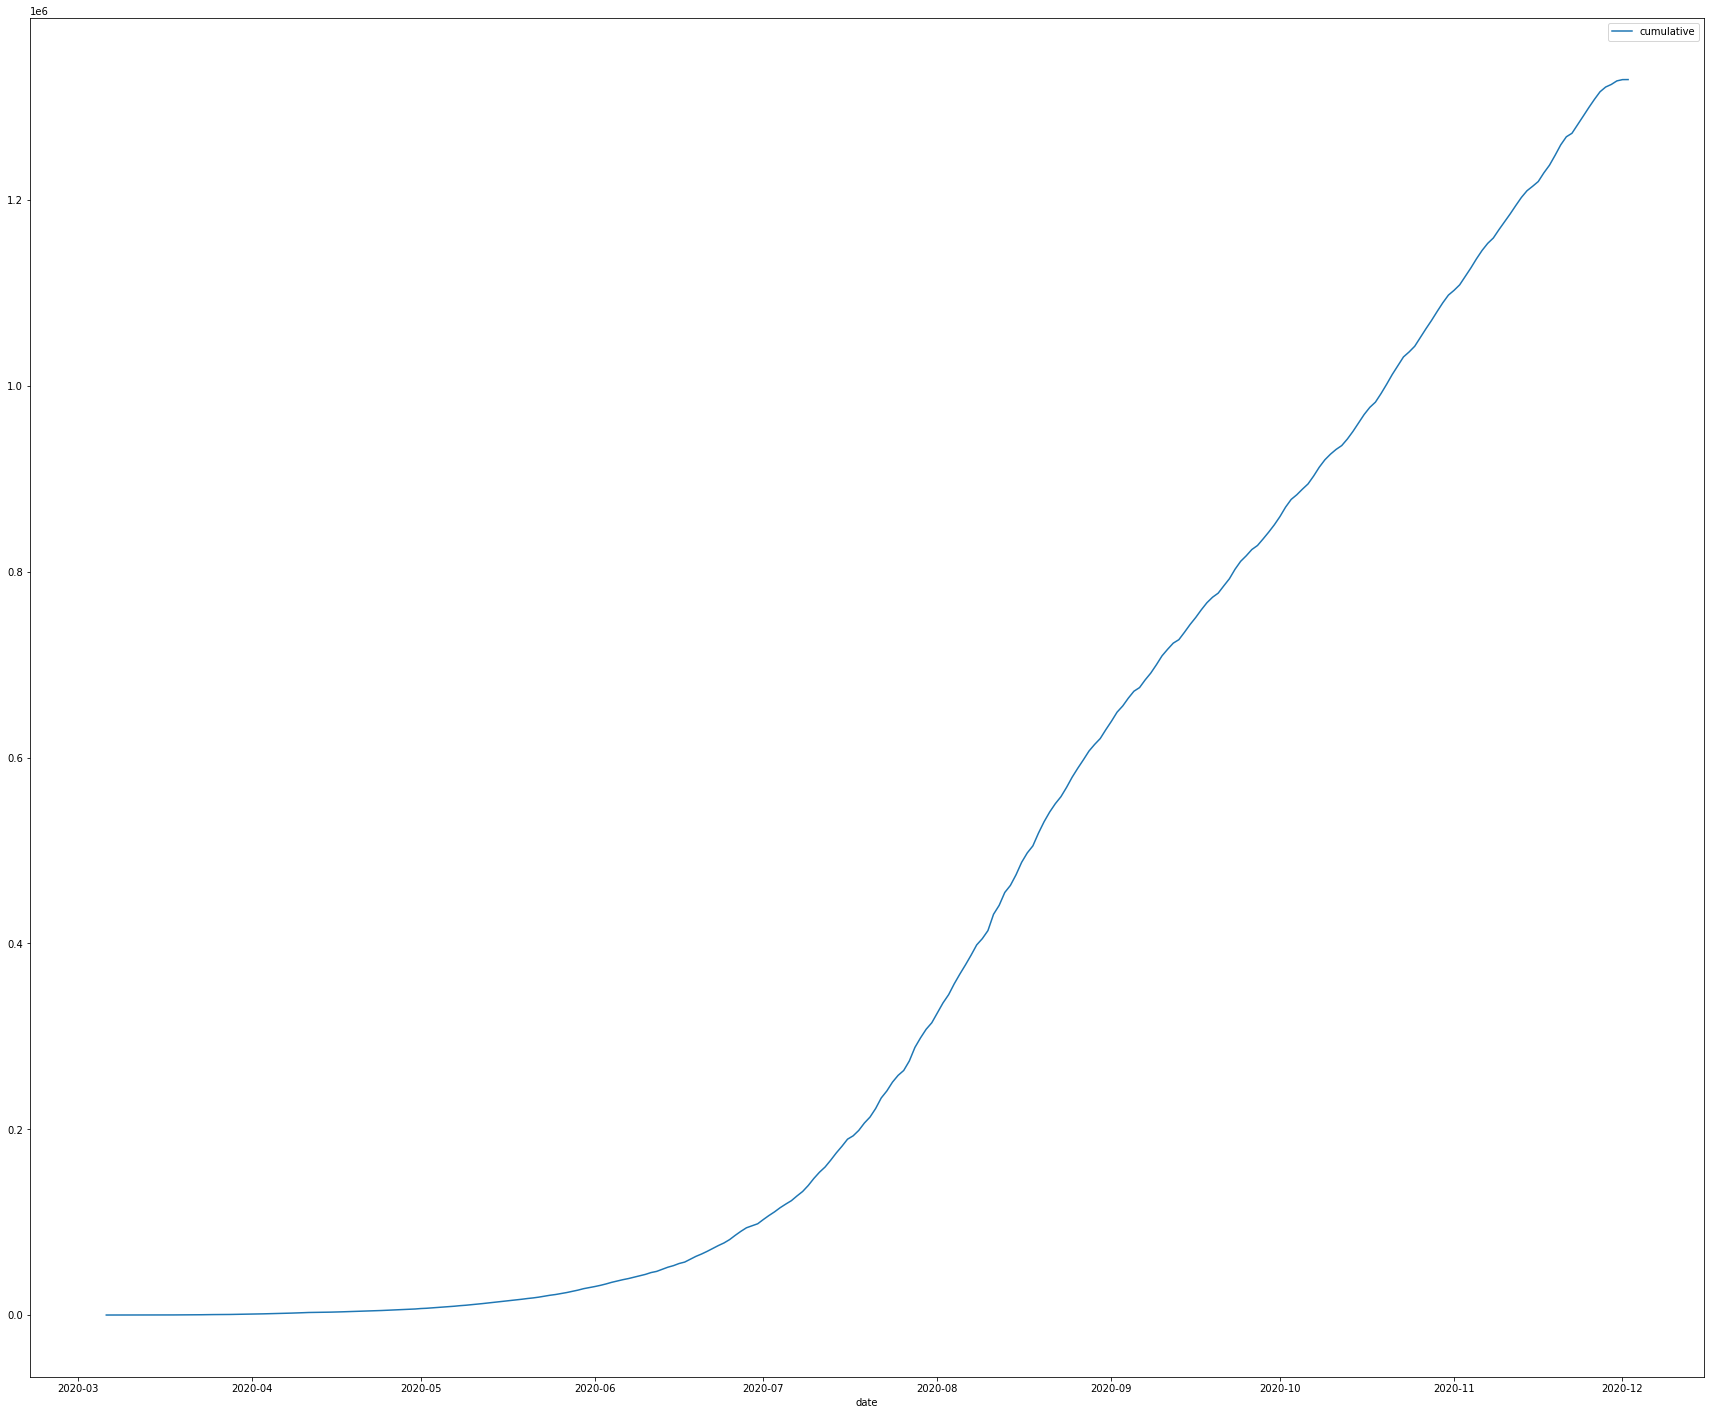

In [325]:
graph_df_evolution_cases_general = df_cases_evolution_general.copy()

graph_df_evolution_cases_general['cumulative'].plot(legend=True, figsize = (30, 25))

<AxesSubplot:xlabel='date'>

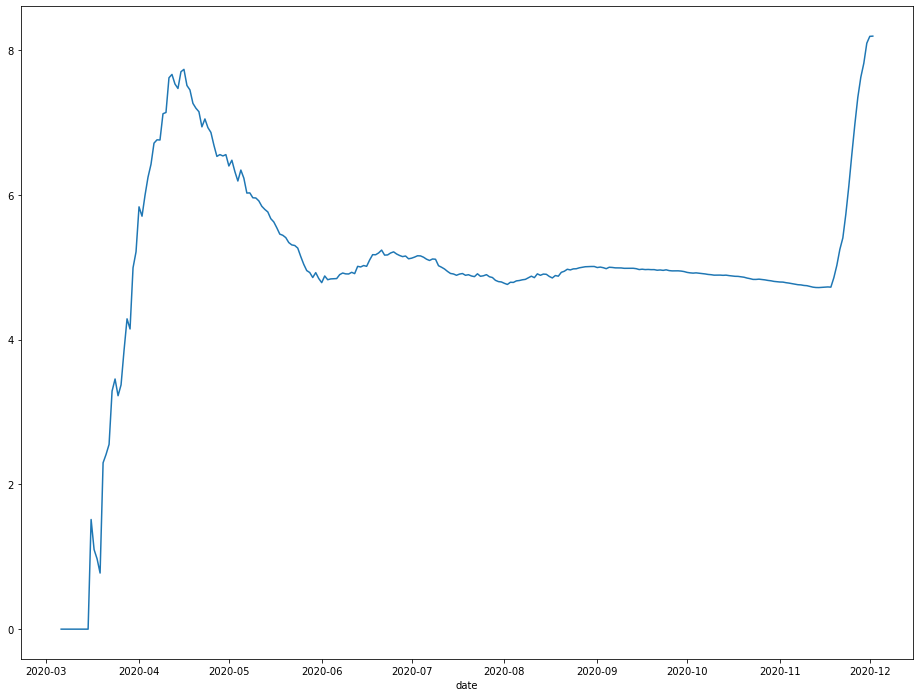

In [326]:
df_cases_evolution_general['cumulative_recovered_difference'].plot()

## NLP

In the analysis of the unstructured data like text from different sources like 'El Tiempo' and Twitter API, I make and approach to analyze the word cloud and ngrams, that for make and easy and fast inference about how is felling the people (Twitter API) and several statements of news and goverment (El Tiempo NEWS). To take in consideration to remove certain 'noise' from the word cloud I decided to eliminate certain words in the context of the I'm analyzing the COVID-19 in Colombia, I delete the following words from the dataset: ['covid', 'https', 'http', 't', 'co', 'colombia', 'rt', 'caso', 'casos']. Certain words are for 'El Tiempo' and others like 'https, http, t, co and rt' are for eliminate noise from twitter data. 

In [26]:
months_dict = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Julio",
    7: "Junio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

### News from 'El Tiempo'

For getting the data from news mineable view, I query data to get the date and get the certain month this for analyze the word cloud by month.

In [27]:
query_news = '''
    SELECT
        Pivot.titulo AS Title,
        Pivot.resumen AS Resume,
        Pivot.cal_date AS Date,
        Pivot.month AS Month,
        Pivot.qtr AS Quarter
    FROM (
        SELECT
        N.titulo,
        N.resumen,
        D.cal_date,
        D.month,
        D.qtr
        FROM news N INNER JOIN dates D ON D.date_id = N.date_id ORDER BY D.cal_date
    ) AS Pivot ORDER BY Pivot.cal_date; 
'''

df_news = pd.read_sql(query_news, connector)
df_news['aggregate_text'] = df_news['title'] + df_news['resume']
df_news['month'] = df_news['month'].apply(lambda x: int(x.strip()))
df_news

title  \
0    el covid   una amenaza mundial que deja más de...   
1    coronavirus tiene nombre oficial  oms lo bauti...   
2    así sería la cuarentena en el país para los co...   
3    no se ha confirmado ningún caso de coronavirus...   
4    así será la evacuación y llegada de los colomb...   
..                                                 ...   
861  minsalud dice que por ahora no pedirá pruebas ...   
862  europa decide sobre primera vacuna covid  ante...   
863  colombia registra  muertes más y   nuevos caso...   
864  vacuna a toda costa  reflexiones tras días de ...   
865  alborada en antioquia deja los tres primeros l...   

                                                resume        date  month  \
0    según advirtió la organización mundial de la s...  2020-02-11      2   
1    nace del acrónimo en inglés a partir de la exp...  2020-02-11      2   
2    los  connacionales que serán evacuados de chin...  2020-02-18      2   
3    directivas del centro hospitalario indicaron q...  2020-02-19      2   
4    ministerio de salud sostiene que el viaje part...  2020-02-21      2   
..                                                 ...         ...    ...   
861  cartera envió preguntas al juez que con tutela...  2020-12-01     12   
862  agencia europea de medicamentos  ema  puso pla...  2020-12-01     12   
863  el ministerio de salud reportó también   recup...  2020-12-01     12   
864  análisis de alejandro gaviria  tatiana andia  ...  2020-12-01     12   
865  son dos menores y un joven de  años en medellí...  2020-12-01     12   

    quarter                                     aggregate_text  
0     1      el covid   una amenaza mundial que deja más de...  
1     1      coronavirus tiene nombre oficial  oms lo bauti...  
2     1      así sería la cuarentena en el país para los co...  
3     1      no se ha confirmado ningún caso de coronavirus...  
4     1      así será la evacuación y llegada de los colomb...  
..      ...                                                ...  
861   4      minsalud dice que por ahora no pedirá pruebas ...  
862   4      europa decide sobre primera vacuna covid  ante...  
863   4      colombia registra  muertes más y   nuevos caso...  
864   4      vacuna a toda costa  reflexiones tras días de ...  
865   4      alborada en antioquia deja los tres primeros l...  

[866 rows x 6 columns]

To start the NLP analysis in the news dataset first I remove stop words with sklearn library to create a bag of words that is a matrix of words with their frecuency, transposing the data to have in axis 1 the month and in axis 0 the word and the value is the frecuency of the word in each month.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish') + ['covid', 'https', 'http', 't', 'co', 'colombia', 'rt', 'caso', 'casos'])

cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(df_news.aggregate_text)
originl_news_data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
originl_news_data.index = df_news.month
data_dtm = originl_news_data.groupby(originl_news_data.index).sum()
data_dtm = data_dtm.transpose()
data_dtm.sort_values(data_dtm.columns.tolist())[-30:]

month        2   3   4   5   6   7   8   9   10  11  12
eleva         1   2   0   0   0   0   0   0   0   1   0
organismo     1   2   0   1   0   1   2   1   2   0   0
cuidados      1   2   1   1   0   0   0   0   0   0   0
aumentan      1   2   1   1   0   2   0   0   0   1   0
tener         1   3   0   0   3   0   2   2   0   4   0
confirmó      1   3   1  12   5   1   0   4   4   0   0
riesgo        1   3   2   5   2   2   1   4   4   6   0
mundo         1   4   2   1   3   1   1   5   2   0   0
confirmados   1   5   0   3   3   1   2   1   0   1   0
personas      1   5   5   1   3   2   2   3   3   8   0
pruebas       1   6   7   3   2   7   8   3   1   2   1
minsalud      1   6  11   4  22   5  19  18  11   8   1
pandemia      1   6  14  12  11   9  14  16  16   3   0
país          1  20  12  10  19  17  21  18  16   4   0
trajo         2   0   0   0   0   0   0   0   0   0   0
posibilidad   2   0   0   0   0   0   1   2   0   0   0
amenaza       2   0   0   0   1   0   1   0   0   0   0
avión         2   0   1   0   0   0   0   0   0   0   0
mundial       2   0   1   0   0   1   1   0   2   1   0
circulan      2   1   0   0   2   0   0   0   1   0   0
virus         2   3   3   4   6  10   5   6   5   7   0
así           2   3   5   4   3   4   2   2   2   2   0
días          2   5   2   2   2   1   2   2   8   3   1
salud         2  26  25  28  12  28  22  21  13  19   2
cuarentena    3   5   4   4   0   2   3   2   1   1   0
wuhan         4   1   0   0   1   1   0   0   0   0   0
oms           4   4   4   5   2   3   4   3   1   5   0
colombianos   5   2   0   0   2   1   2   0   0   1   0
coronavirus   6  39  24  26  17  15  14  13  10   9   0
china         8   1   0   2   1   1   2   0   0   0   0

To create a word cloud I need to clean original data, specifically aggregate_text column, this because I don't want that my cloud has noise.

In [50]:
from nltk.tokenize import word_tokenize

data_clean = df_news[['month', 'aggregate_text']].copy()
data_clean.set_index(['month'], inplace = True)
data_clean = data_clean.groupby(data_clean.index).transform(lambda x: ','.join(x))
data_clean.drop_duplicates(inplace = True)

def remove_stopword(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    filtered_sentence = []  

    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(w)
            
    return ' '.join(filtered_sentence)

data_clean.aggregate_text = data_clean.aggregate_text.apply(lambda x: remove_stopword(x))
data_clean

aggregate_text
month                                                   
2      amenaza mundial deja muertossegún advirtió org...
3      eleva alto riesgo coronavirus lleguecasos dos ...
4      tres muertes inquietanno presentaban comorbili...
5      confirman actor antonio bolívar murió coronavi...
6      van contagios recuperados además minsalud conf...
7      reportan nuevos muertos país van casosya recup...
8      rusia concluye pruebas clínicas primera vacuna...
9      puede confirmar reinfección sars cov colombiaa...
10     posibles nuevos picos ¿y ahora hacer expertos ...
11     director oms cuarentena tras contacto positivo...
12     minsalud dice ahora pedirá pruebas pcr entrar ...

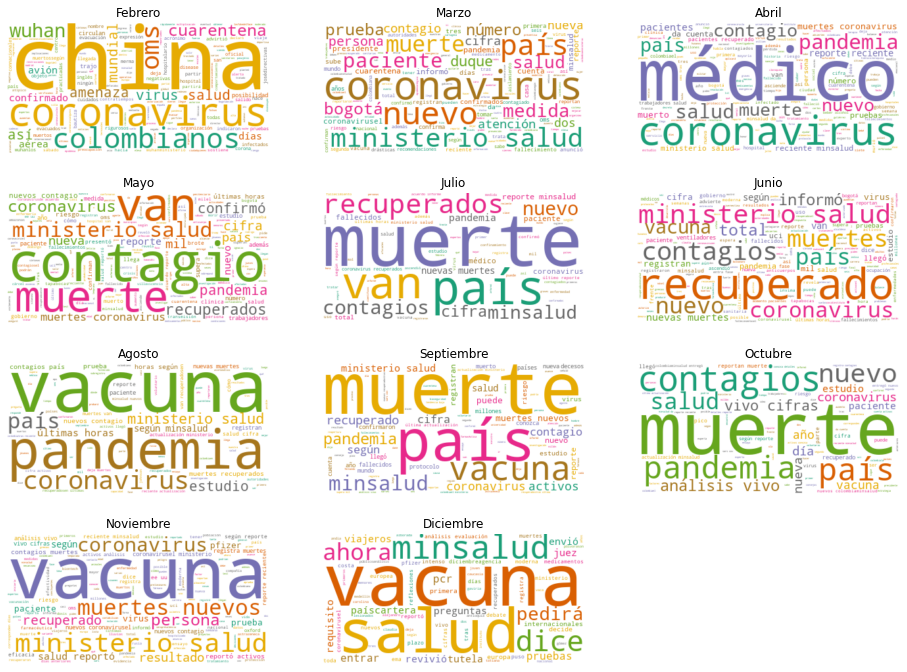

In [51]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,12]

for index, month in enumerate(data_dtm.columns):
    wc.generate(data_clean.aggregate_text[month])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(months_dict[month])
plt.show()

Analyzing the word cloud I notice that in the first four months I found words like: Cuarentena, Prueba, Médico, Salud, Medidas, Contagio, Atención and entities Like Ministerio de Salud, That make sense because the first months of the pandemic the goverments and the news try to socialize the implications of the pandemic and take the more restrictives actions to control the spread of the virus, like I see in analysis of the curve in Evolution Cases by departament and general, but since July the goverment and news statements change drastically we can see words like: Recuperado, Estudio and began to see the word 'Vacuna' and thats curious because if we see the curve beahivoir since July we can see a growth in general in the majority of departaments in daily cases but a minimun amount of test do it per day, that reflects and strategy change of news and goverment in the figth with the pandemic. 

In [60]:
c_vec = CountVectorizer(stop_words = stop_words, ngram_range=(2,3))
ngrams = c_vec.fit_transform(df_news['aggregate_text'])
count_values = ngrams.toarray().sum(axis = 0)
vocab = c_vec.vocabulary_

df_tweets_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_tweets_ngram[:20]

frequency             bigram/trigram
0         111           ministerio salud
1          47             nuevas muertes
2          40           nuevos contagios
3          32              últimas horas
4          30             muertes nuevos
5          28           reporte reciente
6          24                vivo cifras
7          24        muertes coronavirus
8          24       análisis vivo cifras
9          24              análisis vivo
10         21              según reporte
11         21          reciente minsalud
12         20              salud reportó
13         20  reporte reciente minsalud
14         20        muertes recuperados
15         19           reporte minsalud
16         19   ministerio salud reportó
17         18             según minsalud
18         18          muertes contagios
19         18          cifra recuperados

Analyzing the ngram data, I notice that more used ngram words are realtionship with health, evolution of the pandemic and informative reports to general population.

### Twitter Data

To have in consideration about Twitter API, the max range of days that I can gatter information about general Twitter information in Colombia is 4 days, for that the anaylizing of crossed information with news and pandemic evolution in cases and test done can't be do it at the moment, but I can analyze the most used words in a little range of days in the past, that give me information about feelings of the population in social medias.

In [59]:
query_news = '''
    SELECT
        Pivot.texto AS Texto,
        Pivot.cal_date AS Date,
        Pivot.month AS Month,
        Pivot.day AS Day,
        Pivot.qtr AS Quarter
    FROM (
        SELECT
        T.texto,
        D.cal_date,
        D.month,
        D.day,
        D.qtr
        FROM tweets T INNER JOIN dates D ON D.date_id = T.date_id ORDER BY D.cal_date
    ) AS Pivot ORDER BY Pivot.cal_date; 
'''

df_tweets = pd.read_sql(query_news, connector)
df_tweets

texto        date  month  \
0    rt  coronavirusnewv  🇨🇴   colombia   se regist...  2020-11-29  11      
1    rt  wradiocolombia   actualidad   colombia alc...  2020-11-29  11      
2    rt  wradiocolombia   actualidad   bogotá ocupa...  2020-11-29  11      
3    a colombia cuando llegarán las vacunas contra ...  2020-11-29  11      
4    rt  odpdh   colombia 🇨🇴  comunicado conjunto a...  2020-11-29  11      
..                                                 ...         ...    ...   
843  si señores  colombia al mismo nivel que áfrica...  2020-12-02  12      
844   yorecomiendo conversatorio vacunas  status ac...  2020-12-02  12      
845  rt    titulares de miércoles  de diciembre en ...  2020-12-02  12      
846  rt  antoncaballeroh  el   también ha traído al...  2020-12-02  12      
847  rt  redmasnoticias  🎥 video   pacientes con   ...  2020-12-02  12      

     day quarter  
0    29    4      
1    29    4      
2    29    4      
3    29    4      
4    29    4      
..   ...     ...  
843  2     4      
844  2     4      
845  2     4      
846  2     4      
847  2     4      

[848 rows x 5 columns]

I repeat the procees of news analysis to create a bag of words eliminating the stop words of the mineable view.

In [61]:
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(df_tweets.texto)
originl_news_data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
originl_news_data.index = df_tweets.day
data_dtm = originl_news_data.groupby(originl_news_data.index).sum()
data_dtm = data_dtm.transpose()
data_dtm

day             1    2    29   30 
abajo             0    0    1    0
abastecimiento    0    0    0    1
aborto            0    1    0    0
abran             0    0    0    1
abril             2    0    0    0
...             ...  ...  ...  ...
últimos           3    6    0    0
únanse            0    0    0    1
únete             2    2    0    0
única             0    0    1    0
único             1    2    1    0

[3245 rows x 4 columns]

In [63]:
data_clean = df_tweets[['day', 'texto']]
data_clean.set_index(['day'], inplace = True)
data_clean = data_clean.groupby(data_clean.index).transform(lambda x: ','.join(x))
data_clean.drop_duplicates(inplace = True)


data_clean.texto = data_clean.texto.apply(lambda x: remove_stopword(x))
data_clean

texto
day                                                   
29   coronavirusnewv 🇨🇴 registran nuevos coronaviru...
30   lomejordelanoche inscolombia entregó primeros ...
1    aprobado senado proyecto ley vacunas busca gra...
2    ticketcode raíz mundo vive boom eventos virtua...

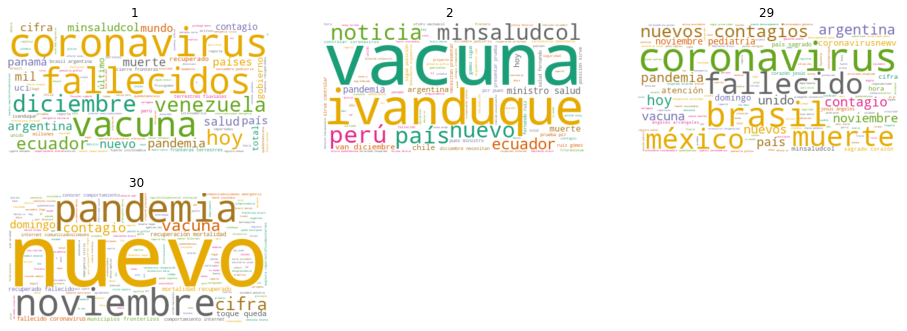

In [64]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

for index, day in enumerate(data_dtm.columns):
    wc.generate(data_clean.texto[day])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(day)
plt.show()

Viewing the word cloud of the last 4 days we notice how in the social medias we start see words like: Fallecidos, Vacuna, Nuevos Contagios and politicians like Ivan Duque, that contrast with the evolution of the pandemic in Colombia since pandamic in Colombia has static numbers of daily cases and the curve seems to be stationary with minimun variations in daily cases, the population start talking about the vaccine and politicians that take actions, of course I can start viewing words that are other countries, like Brasil, Mexico, Perú and others, and if we view the word cloud of the news of December we can see words like "viajeros" and "pais", because the last actions taken by goverment is to open the country to new travelers and trying to reactivate the economy of the country.

In [37]:
c_vec = CountVectorizer(stop_words = stop_words, ngram_range=(2,3))
ngrams = c_vec.fit_transform(df_tweets['texto'])
count_values = ngrams.toarray().sum(axis = 0)
vocab = c_vec.vocabulary_

df_tweets_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_tweets_ngram

frequency                      bigram/trigram
0             29    recuperado fallecido coronavirus
1             29                recuperado fallecido
2             29  recuperación mortalidad recuperado
3             29             recuperación mortalidad
4             29     mortalidad recuperado fallecido
...          ...                                 ...
11077          1                 aborto antiviral si
11078          1                    aborto antiviral
11079          1    abastecimiento nutrición hogares
11080          1            abastecimiento nutrición
11081          1                    abajo bdzaipzewj

[11082 rows x 2 columns]

The ngram dataframe tells me that what most people are talking about is of the recovered and death people, that make sense because Colombia have thousands or cases each day, without variations or views of decrease.